In [13]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Import necessary libraries and modules
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns


In [15]:
# Load training data
tr1_data = pd.read_csv('/content/drive/MyDrive/FML-assignment/data/training1.csv')
tr2_data = pd.read_csv('/content/drive/MyDrive/FML-assignment/data/training2.csv')
# Load testing data
testing_data = pd.read_csv('/content/drive/MyDrive/FML-assignment/data/test.csv')

In [16]:
# Impute missing values in `training2_data`
imputer = SimpleImputer(strategy='mean')
tr2_data_imputed = pd.DataFrame(imputer.fit_transform(tr2_data), columns=tr2_data.columns)

# Combine `training1_data` (unchanged) with the imputed `training2_data`
training_data = pd.concat([tr1_data, tr2_data_imputed], ignore_index=True)

# Separate features and labels
features_data = training_data.drop(columns=['label', 'confidence'])
labels = training_data['label']
confidence = training_data['confidence']

# Impute missing values in combined training data
features_imputed = imputer.fit_transform(features_data)

In [17]:
# Normalize the data
scaler = StandardScaler()
normalised_features = scaler.fit_transform(features_imputed)

# Feature selection
selector = SelectKBest(score_func=f_classif, k=100)
features_selected = selector.fit_transform(normalised_features, labels)

# Dimensionality reduction
pca = PCA(n_components=0.95)
features_pca = pca.fit_transform(features_selected)

In [18]:
# Train-validation split
x_train, x_val, y_train, y_val, c_training, c_validation = train_test_split(
    features_pca, labels, confidence, test_size=0.2, random_state=42, stratify=labels)

# Apply sample weighting based on confidence
sample_weights = c_training

In [19]:
# Initialize models
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "MLP": MLPClassifier(random_state=42),
    "SingleLayerPerceptron": Perceptron(random_state=42),
    "LogisticRegression": LogisticRegression(random_state=42)
}

# Define hyperparameters for grid search
param_grids = {
    "RandomForest": {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30],
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    },
    "MLP": {
        'solver': ['sgd', 'adam'],
        'alpha': [1e-5, 1e-4, 1e-3],
        'hidden_layer_sizes': [(5, 2), (10, 5), (50, 20)]
    },
    "SingleLayerPerceptron": {
        'max_iter': [100, 300, 500],
        'penalty': ['l2', 'elasticnet'],
        'alpha': [0.0001, 0.001, 0.01]
    },
    "LogisticRegression": {
        'C': [0.1, 1, 10],
        'penalty': ['l2', 'elasticnet'],
        'solver': ['saga']
    }
}


In [20]:
# Perform grid search for each model
best_estimators = {}
best_scores = {}
best_params = {}
for name, model in models.items():
    print(f"Running GridSearchCV for {name}...")
    search = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
    if name in ["RandomForest", "SVM", "SingleLayerPerceptron", "LogisticRegression"]:
        search.fit(x_train, y_train, sample_weight=sample_weights)
    else:
        search.fit(x_train, y_train)
    best_estimators[name] = search.best_estimator_
    best_scores[name] = search.best_score_
    best_params[name] = search.best_params_
    print(f"Best parameters for {name}: {search.best_params_}")
    print(f"Best cross-validated score for {name}: {search.best_score_}")

# Evaluate best models on validation set
validation_accuracies = {}
for name, model in best_estimators.items():
    y_val_pred = model.predict(x_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    validation_accuracies[name] = accuracy

Running GridSearchCV for RandomForest...
Best parameters for RandomForest: {'max_depth': 20, 'n_estimators': 100}
Best cross-validated score for RandomForest: 0.7476190476190476
Running GridSearchCV for SVM...
Best parameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validated score for SVM: 0.7507936507936508
Running GridSearchCV for MLP...


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLP: {'alpha': 1e-05, 'hidden_layer_sizes': (10, 5), 'solver': 'sgd'}
Best cross-validated score for MLP: 0.7436507936507936
Running GridSearchCV for SingleLayerPerceptron...
Best parameters for SingleLayerPerceptron: {'alpha': 0.001, 'max_iter': 100, 'penalty': 'elasticnet'}
Best cross-validated score for SingleLayerPerceptron: 0.7297619047619047
Running GridSearchCV for LogisticRegression...


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1291, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose, prefer=prefer)(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iter

Best parameters for LogisticRegression: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validated score for LogisticRegression: 0.7321428571428571


In [21]:

# Create a DataFrame for the results
results_df = pd.DataFrame({
    'Model': list(validation_accuracies.keys()),
    'Validation Accuracy': list(validation_accuracies.values()),
    'Best Cross-Validated Score': list(best_scores.values()),
    'Best Parameters': list(best_params.values())
})

# Display the results table
print(results_df.to_markdown(index=False))

| Model                 |   Validation Accuracy |   Best Cross-Validated Score | Best Parameters                                                  |
|:----------------------|----------------------:|-----------------------------:|:-----------------------------------------------------------------|
| RandomForest          |              0.747619 |                     0.747619 | {'max_depth': 20, 'n_estimators': 100}                           |
| SVM                   |              0.749206 |                     0.750794 | {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}                      |
| MLP                   |              0.765079 |                     0.743651 | {'alpha': 1e-05, 'hidden_layer_sizes': (10, 5), 'solver': 'sgd'} |
| SingleLayerPerceptron |              0.746032 |                     0.729762 | {'alpha': 0.001, 'max_iter': 100, 'penalty': 'elasticnet'}       |
| LogisticRegression    |              0.749206 |                     0.732143 | {'C': 0.1, 'penalty': 'l2', 'so

<ipython-input-22-e77504ef8a6b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Validation Accuracy', data=results_df, palette='viridis')


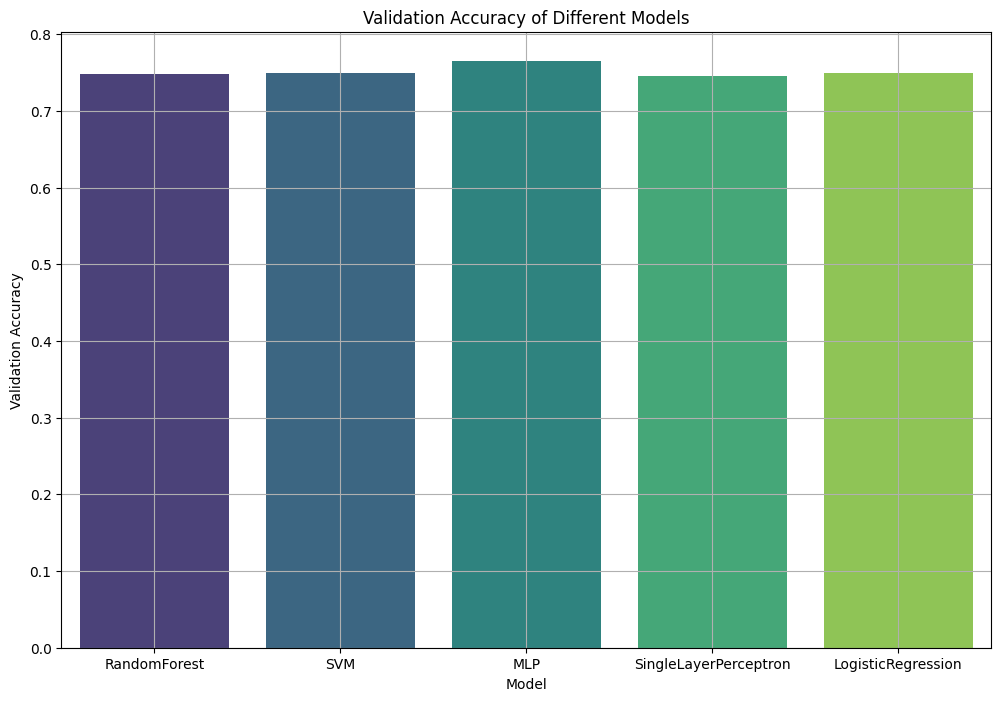

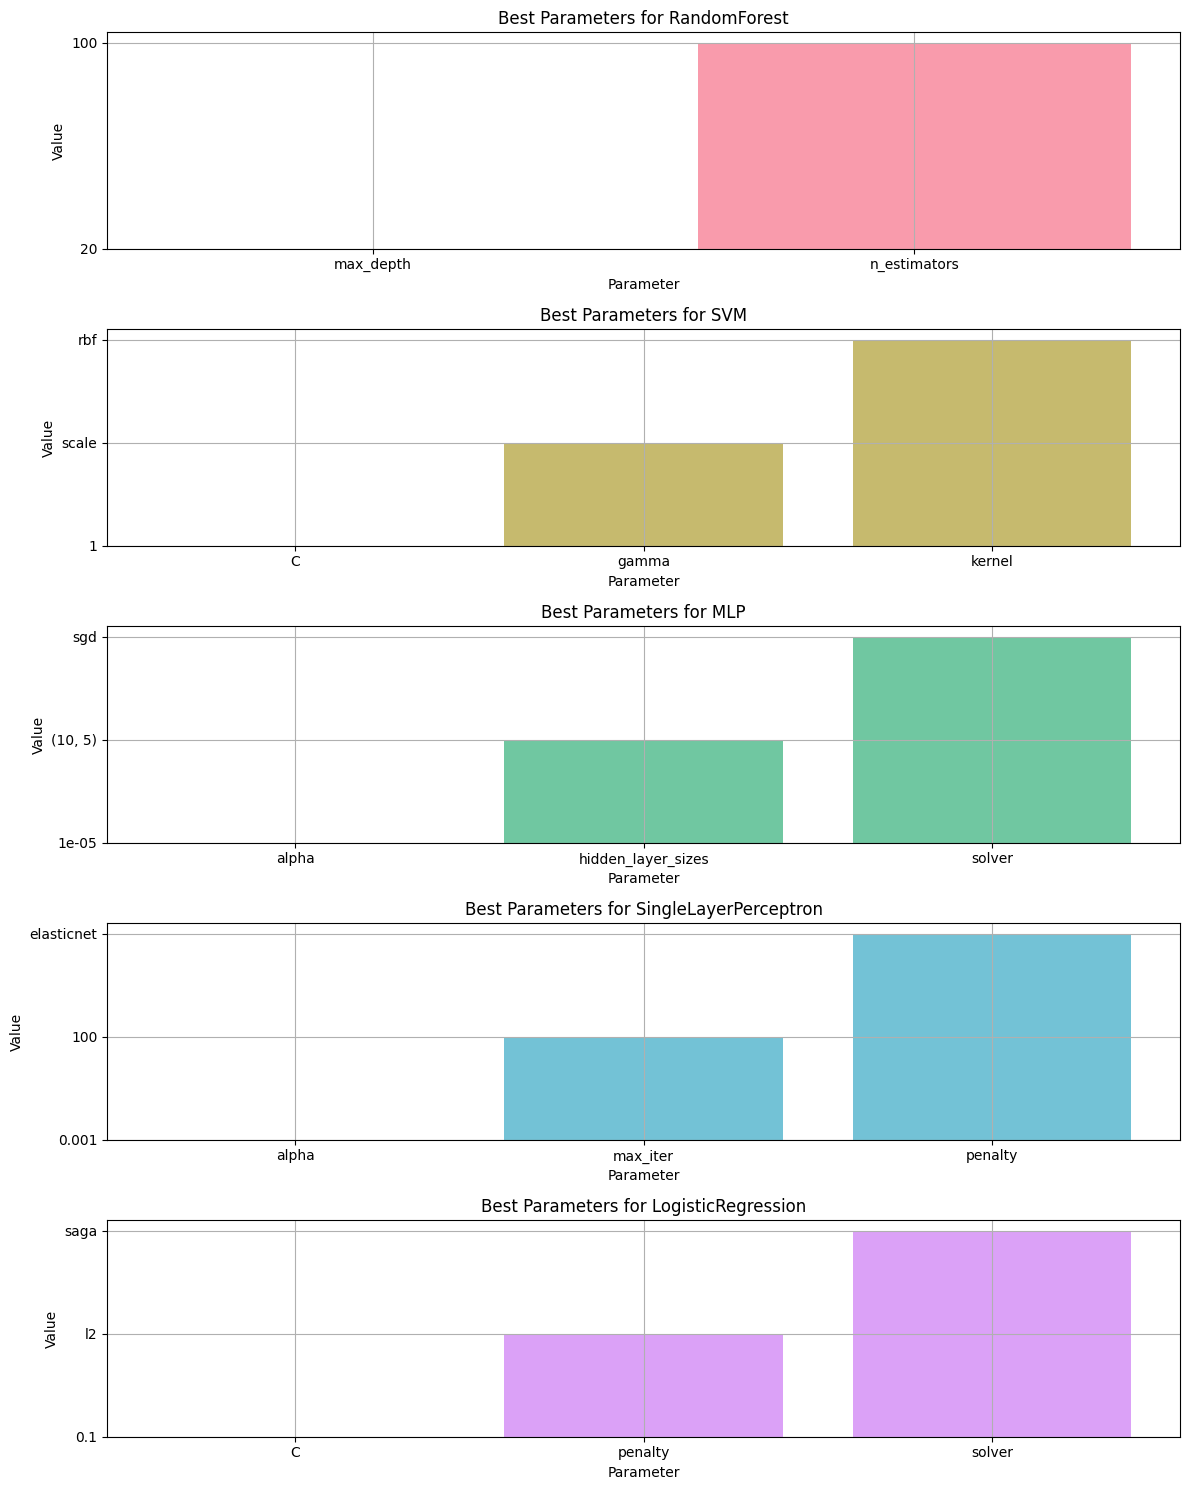

In [22]:


# Plotting the validation accuracies using a colorful bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Model', y='Validation Accuracy', data=results_df, palette='viridis')
plt.xlabel('Model')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy of Different Models')
plt.grid(True)
plt.show()

# Plotting best parameters for each classifier
fig, ax = plt.subplots(len(best_params), 1, figsize=(12, len(best_params) * 3))
colors = sns.color_palette('husl', len(best_params))

for i, (model, params) in enumerate(best_params.items()):
    param_values = [str(p) for p in params.values()]
    param_names = params.keys()
    ax[i].bar(param_names, param_values, color=colors[i], alpha=0.7)
    ax[i].set_title(f"Best Parameters for {model}")
    ax[i].set_xlabel('Parameter')
    ax[i].set_ylabel('Value')
    ax[i].grid(True)

plt.tight_layout()
plt.show()

In [23]:

# Voting classifier with the best models
voting_classifier = VotingClassifier(estimators=[
    (name, model) for name, model in best_estimators.items()
], voting='hard')

# Train the voting classifier
voting_classifier.fit(x_train, y_train)
y_validation_voting_pred = voting_classifier.predict(x_val)
voting_accuracy = accuracy_score(y_val, y_validation_voting_pred)
print(f"Voting Classifier Accuracy on Validation Set: {voting_accuracy}")

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Voting Classifier Accuracy on Validation Set: 0.7587301587301587


In [24]:
# Preprocess the test data
testing_imputed = imputer.transform(testing_data)
testing_normalised = scaler.transform(testing_imputed)
testing_data_selected = selector.transform(testing_normalised)
testing_data_pca = pca.transform(testing_data_selected)

# Generate predictions on the test set using the voting classifier
test_predictions = voting_classifier.predict(testing_data_pca)
test_predictions_df = pd.DataFrame({'prediction': test_predictions})

# Save predictions to CSV
csv_path = '/content/drive/MyDrive/FML-assignment/data/predictions.csv'
test_predictions_df.to_csv(csv_path, index=False)
print(f"Predictions for Voting Classifier have been saved to {csv_path}.")


Predictions for Voting Classifier have been saved to /content/drive/MyDrive/FML-assignment/data/predictions.csv.
